# Exercício 6 - Algoritmo Árvores de Decisão com ID3

## Importando as bibliotecas para construção do algoritmo

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import math
from graphviz import Digraph

## Carregando e preparando dados do Iris Dataset

In [2]:
# Importanto o dataset do Scikit Learn
iris = load_iris()

# Convertendo o dataset em um DataFrame
data = pd.DataFrame(data=np.c_[iris['data'], iris['target']], 
                    columns=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species'])

# Renomeando as espécies conforme a especificação do dataset
data['Species'].replace({0: 'Setosa', 1: 'Versicolour', 2: 'Virginica'}, inplace=True)

## Classes para as estruturas de dados utilizadas

#### Classe Árvore
Armazena o resultado do ID3

In [3]:
class Tree:
    def __init__(self, root=None):
        self.root = root

#### Classe Nó
Classe base com referências para os filhos esquerdo e direito de cada nó da árvore

In [4]:
class Node:
    def __init__(self):
        self.left = None
        self.right = None

#### Classe Nó Condicional
Representa um nó intermediário da árvore, que guarda uma condição utilizando um dos atributos do dataset

In [5]:
class ConditionNode(Node):
    def __init__(self, attribute, threshold):
        self.attribute = attribute
        self.threshold = threshold

#### Nó Resultado (Rótulo)
Representa um nó folha, isto é, um nó com um resultado para as condições anteriores da árvore

In [6]:
class LabelNode(Node):
    def __init__(self, label):
        self.label = label

#### Função Entropia

In [7]:
# Recebe os dados de entrada e os possíveis resultados
def entropy(dataset, outcomes=['Setosa', 'Versicolour', 'Virginica']): 
    _entropy = 0 # Inicializa a entropia
    
    # Itera sobre os possíveis resultados
    for outcome in outcomes: 
        # Obtém o número de registros no dataset para um dado resultado
        outcome_counter = len(dataset[dataset['Species'] == outcome]) 
        # Calcula a proporção de registros frente ao tamanho do dataset
        proportion = outcome_counter / len(dataset)
        # Calcula a entropia. Considera-se 0*log(0) = 0
        _entropy -= 0 if proportion == 0 else proportion * math.log2(proportion)
    
    # Retorna a entropia calculada
    return _entropy

#### Função para o somatório ponderado da entropia dos sub-conjuntos
Função utilizada para calcular o segundo termo da função de ganho, buscando o melhor limiar entre os possíveis para um dado atributo, a fim de maximizar seu ganho

In [8]:
# Função para calcular o somatório das entropias para cada subconjunto do dataset
def split_entropy(dataset, attribute): # Recebe os dados de entrada e o nome de um atributo do dataset
    thresholds = dataset[attribute].unique() # Obtém os valores distintos do atributo especificado no dataset
    thresholds.sort() # Ordena o vetor de valores
    thresholds = thresholds[:-1] # Remove o último valor do vetor
    
    best_threshold = None # Inicializa a variável de melhor limiar
    _best_split_entropy = None # inicializa a variável de melhor entropia
    
    # Itera sobre todos os possíveis limiares
    for index, threshold in enumerate(thresholds):
        # Filtra o dataset, com base no atributo recebido, para valores menores ou iguais ao limiar
        less_or_equal_set = dataset[dataset[attribute] <= threshold]
        # Filtra o dataset, com base no atributo recebido, para valores maiores do que o limiar
        greater_set = dataset[dataset[attribute] > threshold]
        
        # Calcula a entropia do primeiro dataset
        less_or_equal_entropy = entropy(less_or_equal_set)
        # Calcula a entropia do segundo dataset
        greater_entropy = entropy(greater_set)
        
        # Calcula a soma das entropias, ponderada pelo tamanho do dataset
        result = len(less_or_equal_set) / len(dataset) * less_or_equal_entropy + len(greater_set) / len(dataset) * greater_entropy
        
        # Verifica se a nova soma obtida é menor do que a melhor entropia (o que gera um maior ganho para esse limiar)
        if _best_split_entropy is None or result < _best_split_entropy:
            # Caso seja, atualiza o melhor limiar e a melhor entropia
            best_threshold = threshold
            _best_split_entropy = result
            
    # Retorna os resultados obtidos
    return _best_split_entropy, best_threshold

#### Função Ganho

In [9]:
# Recebe o dataset e o nome de um atributo
def gain(dataset, attribute): 
    # Obtém o segundo termo da fórmula pela função 'split_entropy', bem como o limiar usado
    _best_split_entropy, threshold = split_entropy(dataset, attribute)
    # Retorna uma tupla com cálculo do ganho para o melhor limiar do dado atributo e o limiar obtido
    return entropy(dataset) - _best_split_entropy, threshold

#### Função para escolher o melhor atributo
Utiliza a função de ganho para determinar o melhor atributo

In [10]:
# Recebe o dataset e a lista de atributos disponíveis
def get_best_attribute(dataset, attributes):
    best_attribute = None # Inicializa o melhor atributo
    max_gain = None # Inicializa o maior ganho
    attribute_threshold = None # Inicializa o limiar do atributo
     
    # Itera sobre os atributos recebidos
    for attribute in attributes:
        # Calcula o ganho e o limiar para o atributo
        attribute_gain, threshold = gain(dataset, attribute)

        # Verifica se o ganho calcularo é maior que o max_gain
        if max_gain is None or attribute_gain > max_gain:
            # Caso seja, atualiza o ganho, o melhor atributo e o limiar
            max_gain = attribute_gain
            best_attribute = attribute
            attribute_threshold = threshold
            
    # Retorna o melhor atributo e seu limiar
    return best_attribute, attribute_threshold

## Função ID3 (Iterative Dichotomiser)

Função principal para a construção da árvore de decisão, adaptada para o uso com o Iris Dataset.

Desenvolvida com base no pseudo-algoritmo disponível em: https://en.wikipedia.org/wiki/ID3_algorithm

In [11]:
# Recebe o dataset, a árvore, o nó pai, um lado para o 
# nó atual (esquerdo ou direito) e a lista de atributos
def ID3(dataset, tree, parent, side, attributes):
    # Obtém o número de espécies restantes no dataset
    speciesLeft = dataset['Species'].unique()
    
    # Inicializa o nó atual
    currentNode = None
    
    # Se há somente uma espécie no dataset
    if len(speciesLeft) == 1:
        # Atualiza o nó atual para ser um nó folha com o nome da espécie
        currentNode = LabelNode(speciesLeft[0])
        # Adiciona uma referência do nó atual no nó pai
        setattr(parent, side, currentNode)
    # Caso contrário, se não houver mais nenhum atributo disponível
    elif attributes is not None and len(attributes) == 0:
        # Verifica a espécie mais recorrente no dataset recebido
        mostCommonSpecies = dataset['Species'].mode()[0]
        # Atualiza o nó atual para ser um nó folha com o nome da espécie
        currentNode = LabelNode(mostCommonSpecies)
        # Adiciona uma referência do nó atual no nó pai
        setattr(parent, side, currentNode)
    # Caso contrário
    else:
        # Se a lista de atributos estiver nula (caso da primeira chamada do ID3)
        if attributes is None:
            # Atualiza a lista de atributos com todos os disponíveis no dataset
            attributes = list(dataset.columns[:-1])
            
        # Obtém o melhor atributo e seu limiar                
        best_attribute, threshold = get_best_attribute(dataset, attributes)
        # Atualiza o nó atual para ser um nó condicional para o melhor atributo
        currentNode = ConditionNode(best_attribute, threshold)
        
        # Se a árvore está vazia, o nó atual vira raiz
        if tree.root is None:
            tree.root = currentNode
        else: # Senão, o nó atual é associado ao nó pai
            setattr(parent, side, currentNode)
            
        # Remove o melhor atributo da lista de atributos disponíveis
        attributes.remove(best_attribute)

        # Cria uma lista constante com os dois possíveis lados (filhos) para o nó atual
        node_sides = ['left', 'right']

        # Itera sobre a lista de lados
        for node_side in node_sides:
            # Se o lado for esquerdo
            if node_side == 'left':
                # Filtra o dataset com os dados menores ou iguais ao o limiar
                filtered_dataset = dataset[dataset[best_attribute] <= threshold]
            else:
                # Senão, filtra o dataset com os dados maiores do que o limiar
                filtered_dataset = dataset[dataset[best_attribute] > threshold]

            # Se o dataset filtrado estiver vazio
            if len(filtered_dataset) == 0:
                # Obtém a espécie mais recorrente no dataset recebido 
                mostCommonSpecies = dataset['Species'].mode()[0]
                # Cria um nó filho como um nó folha com essa espécie
                labelNode = LabelNode(mostCommonSpecies)
                # Adiciona uma referência desse nó filho no nó atual
                setattr(currentNode, node_side, labelNode)
            # Caso contrário
            else:
                # Chama recursivamente o ID3 enviando o dataset filtrado, a árvore,
                # o nó atual, o lado para o qual o algoritmo será executado e a lista 
                # de atributos disponíveis
                ID3(filtered_dataset, tree, currentNode, node_side, attributes)                

## Funções para exibir a árvore obtida

#### Função para adicionar um nó e suas arestas à árvore
Função recursiva que realiza uma busca em profundidade na árvore para adicionar os nós a um grafo que será desenhado em tela

In [12]:
# Recebe o nó pai, o nó atual, o grafo e um label para a aresta
def add_node(parent, node, graph, label):
    # Se o tipo do nó for um nó folha
    if type(node) == LabelNode:
        # Altera o formato do nó para um retângulo
        graph.attr('node', shape='box')
        # Adiciona o nó ao grafo
        graph.node(node.label)
        # Adiciona uma aresta que liga o pai ao filho e adiciona o label recebido
        graph.edge(parent.attribute, node.label, label)
        return # Retorna
    
    # Caso não seja um nó folha
    # Altera o formato do nó para uma elipse
    graph.attr('node', shape='ellipse')
    # Adiciona o nó ao grafo
    graph.node(node.attribute)
    # Se o nó pai recebido não for nulo
    if parent is not None:
        # Adiciona uma aresta que liga o pai ao filho e adiciona o label recebido
        graph.edge(parent.attribute, node.attribute, label)
    
    # Chama recursivamente a função no filho esquerdo
    add_node(node, node.left, graph, f'<= {node.threshold}')
    
    # Chama recursivamente a função no filho direito
    add_node(node, node.right, graph, f'> {node.threshold}')

#### Função principal para imprimir a árvore

In [13]:
def print_tree(tree): # Recebe a árvore gerada pelo ID3
    iris_graph = Digraph() # Inicializa o grafo 
    # Realiza a primeira chamada da função para adicionar o nó raiz
    add_node(None, tree.root, iris_graph, None)
    # Retorna o grafo gerado
    return iris_graph

### Executando o ID3 e imprimindo o resultado

In [14]:
iris_tree = Tree() # Inicializa a árvore
ID3(data, iris_tree, None, None, None) # Executa o ID3

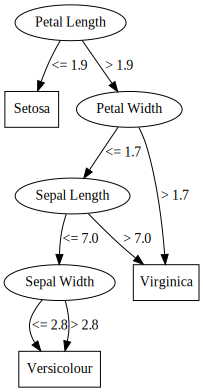

In [15]:
print_tree(iris_tree) # Imprime a árvore obtida